In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,UUID,Major,Minor,RSSI,X,Y,Timestamp,SessId
0,b9407f30f5f8466eaff925556b57fe6d,1,9617,-87,3.337088,1.324216,1493749680685,12
1,b9407f30f5f8466eaff925556b57fe6d,1,9618,-70,3.335436,1.324163,1493749680687,12
2,b9407f30f5f8466eaff925556b57fe6d,1,9619,-85,3.320566,1.323686,1493749680705,12
3,b9407f30f5f8466eaff925556b57fe6d,1,9616,-80,3.318914,1.323633,1493749680707,12
4,b9407f30f5f8466eaff925556b57fe6d,1,9609,-81,3.265217,1.321913,1493749680772,12


In [4]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [5]:
sess = df[df.SessId == 1]

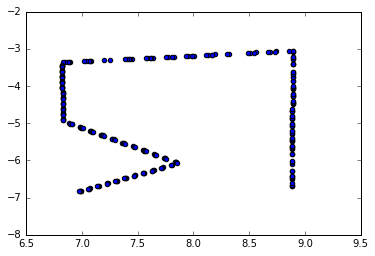

In [6]:
plt.scatter(sess.X, -sess.Y)

In [7]:
def plot_rssi_data(df, figsize=(15, 10), smooth_func=lambda x: x):
    min_time = df.Timestamp.min()
    unique_minors = df.Minor.unique()
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        bd = smooth_func(df[df.Minor == minor])
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.plot(bd.Timestamp-min_time, bd.RSSI)
    
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        bd = smooth_func(df[df.Minor == minor])
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.scatter(bd.X, -bd.Y, c=-bd.RSSI, cmap='Reds')

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import medfilt

In [9]:
def rssi_lowess_smooth(df):
    smoothed = lowess(df.RSSI, df.Timestamp)
    new_df = df.copy()
    new_df.RSSI = smoothed[:, 1]
    new_df.Timestamp = smoothed[:, 0]
    return new_df

In [10]:
def create_rssi_median_filter(kernel=9):
    def median_filter(df):
        smoothed = medfilt(df.RSSI, kernel)
        new_df = df.copy()
        new_df.RSSI = smoothed
        return new_df
    return median_filter

In [11]:
def plot_session(df):
    plt.title("Route")
    plt.scatter(df.X, -df.Y)
    plot_rssi_data(sess, smooth_func=rssi_lowess_smooth)    

In [12]:
def filter_session(sess_df):
    result = pd.DataFrame()
    for minor in sess_df.Minor.unique():
        result = result.append(rssi_lowess_smooth(sess_df[sess_df.Minor == minor]))
    return result

In [13]:
def filter_rssi_df(df):
    result = pd.DataFrame()
    for sess_id in df.SessId.unique():
        result = result.append(filter_session(df[df.SessId == sess_id]))
    return result

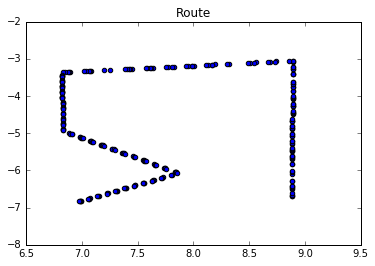

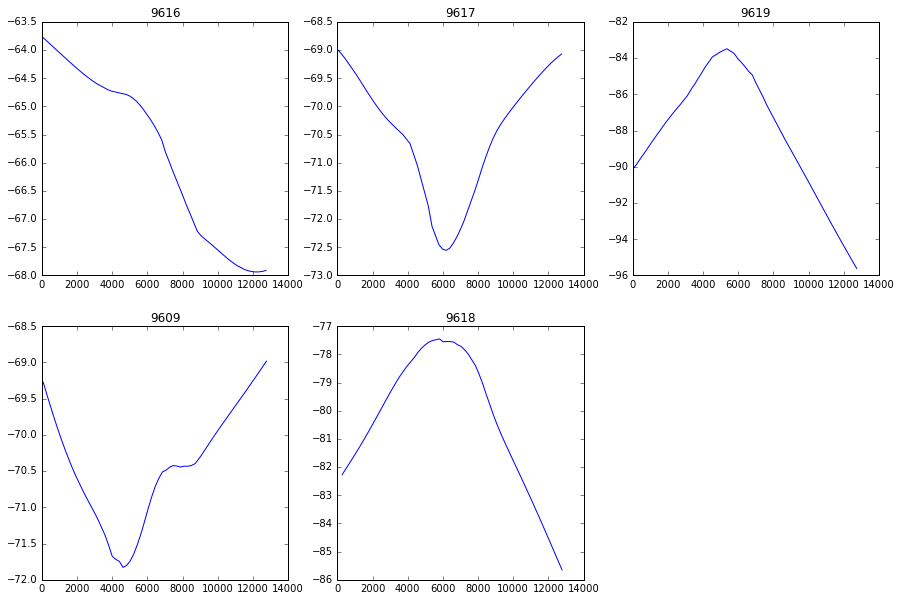

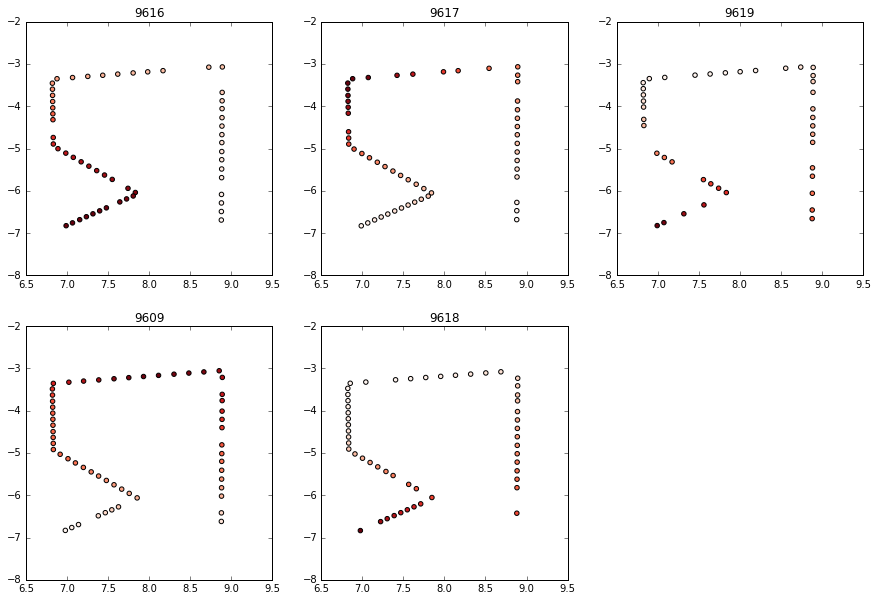

In [14]:
plot_session(sess)

In [15]:
filtered_df = filter_rssi_df(df)

In [16]:
filtered_df.head()

,UUID,Major,Minor,RSSI,X,Y,Timestamp,SessId
0,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.836897,3.337088,1.324216,1.493750e+12,12
5,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.651588,3.171042,1.318895,1.493750e+12,12
9,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.460786,3.007474,1.313654,1.493750e+12,12
13,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.249968,2.835644,1.308147,1.493750e+12,12
18,b9407f30f5f8466eaff925556b57fe6d,1,9617,-84.028896,2.665468,1.302694,1.493750e+12,12


In [18]:
route_1_rssi = pd.read_csv('long_route_1_rssi.txt')
route_1_pos = pd.read_csv('long_route_1_position.txt')

In [19]:
route_1_rssi = route_1_rssi[route_1_rssi.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

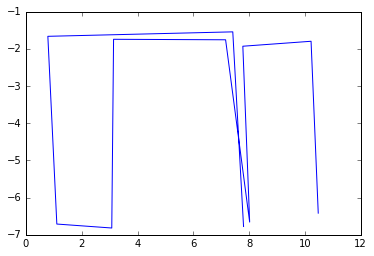

In [21]:
plt.plot(route_1_pos.X, -route_1_pos.Y)

In [22]:
filt_r_1 = filter_session(route_1_rssi)

In [23]:
filt_r_1.head()

,UUID,Major,Minor,RSSI,Timestamp
0,b9407f30f5f8466eaff925556b57fe6d,1,9616,-70.015146,1.493750e+12
4,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.945535,1.493750e+12
8,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.875445,1.493750e+12
13,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.807840,1.493750e+12
22,b9407f30f5f8466eaff925556b57fe6d,1,9616,-69.670250,1.493750e+12


In [24]:
from collections import defaultdict

In [76]:
filt_r_1.Timestamp -= filt_r_1.Timestamp.min()

In [124]:
len(filt_r_1)

925

In [150]:
def build_bins_for_one_minor(rssi_df, n_bins=100):
    bin_w = (rssi_df.Timestamp.max()) / float(n_bins-1)

    result = [[] for _ in range(n_bins)]
    for _, row in rssi_df.iterrows():
        result[int(row.Timestamp // bin_w)].append(row.RSSI)
    return result

In [156]:
def fill_bins(bins):
    for i in range(len(bins)):
        if not bins[i]:
            bins[i] = bins[i - 1].copy()
        bins[i] = np.mean(bins[i])
    return bins

In [157]:
def build_bins(rssi_df):
    bins = {}
    for u in filt_r_1.Minor.unique():
        bins[u] = fill_bins(build_bins_for_one_minor(filt_r_1[filt_r_1.Minor == u]))
    return bins

In [158]:
bins = build_bins(filt_r_1)

In [159]:
bins.keys()

dict_keys([9616, 9609, 9618, 9619, 9617])

In [163]:
for k in zip(bins):
    print(k)

(9616,)
(9609,)
(9618,)
(9619,)
(9617,)
